# Homework 5


## By Team VC

### Document classification with the NLTK Classfiyer

For this week's homework, we created a spam classiyer with NLTK. We will use the [SMS Spam data collection](https://www.kaggle.com/datasets/uciml/sms-spam-collection-dataset?resource=download) for our spam detection purposes. The reason we went with the SMS dataset as there is a rise in mobile phishing. There is a delay in identification of these types of phishing cases as mobile providers fall behind in the text analysis of messages compared to the hundreds of mobile apps for phone type phishing. This delay could be from a privacy policy with the consumer or the developement of these softwares have not reached the final testing stages. Let's simulate what this detection might look like below!

The dataset imported has two useful columns: Ham/spam and its string. We wanted to mirror the data frame given in the Spambase data set for features our classiyer can use. These transfomation included some word frequencies with the forumlas given by [UCI](https://archive.ics.uci.edu/ml/datasets/spambaseet).

In [1]:
# Loading in the data set
import pandas as pd
import numpy as np
import re
from numpy import mean
from sklearn.utils import shuffle
import nltk


data=pd.read_csv('spam.csv', header=0,names=['Spam_Value', 'Str'],usecols=['Spam_Value','Str'],encoding="ISO-8859-1")  

# randomize the data
#data = shuffle(data)

# split the data into a training set (4572 observations) and a test set (1000 observations)
#test_data = data.iloc[4572:]
#data = data.iloc[0:4572]

#flip order of the data frame to use classifyer
flip_df=pd.DataFrame().assign(Str=data['Str'],Spam_Value=data['Spam_Value'])
#print(flip_df)


#collect word counts to calculate frequencies| Word counts| Avgs-> Make a frequnecy chart 
d_stats=pd.DataFrame()
d_stats['spam_ham']=data['Str']

#Find the total word count of the text
d_stats['Word_count']=data['Str'].str.split().str.len()
d_stats['Char_count']=data['Str'].str.len()

#Find all the capital words in the string- metric by UCI
d_stats['capital_run_length_total']=data['Str'].str.count("[A-Z]{2,}")
#d_stats.loc[5:15,]

#Find longest Capital word in the text
def longest_Cap(w):
    l=w.str.findall("[A-Z]{2,}")
    n=[0 if not n else len(max(n,key=len)) for n in l]
    return n

d_stats["capital_run_length_longest"]=longest_Cap(data['Str'])

#Find average capital words in a text | inspo of list avg from geek4geek's Average String length in list
def avg_Cap(w):
    l=w.str.findall("[A-Z]{2,}")
    n=[0 if not n else sum(map(len, n))/float(len(n)) for n in l]
    return n

d_stats["capital_run_length_average"]=avg_Cap(data['Str'])


In [2]:
#Section for words frequenices of our interest, Combo of UCI's word freq and ones we see in spam texts
d_stats['freq_order']=data['Str'].str.count("order",flags=re.I)
d_stats['freq_receive']=data['Str'].str.count("receieve",flags=re.I)
d_stats['freq_will']=data['Str'].str.count("will",flags=re.I)
d_stats['freq_over']=data['Str'].str.count("over",flags=re.I)
d_stats['freq_you']=data['Str'].str.count("you",flags=re.I)
d_stats['freq_your']=data['Str'].str.count("your",flags=re.I)
d_stats['freq_credit']=data['Str'].str.count("credit",flags=re.I)
d_stats['freq_order']=data['Str'].str.count("order",flags=re.I)
d_stats['freq_free']=data['Str'].str.count("free",flags=re.I)
d_stats['freq_alert']=data['Str'].str.count("alert",flags=re.I)
d_stats['freq_urgent']=data['Str'].str.count("urgent",flags=re.I)
d_stats['freq_tried']=data['Str'].str.count("tried",flags=re.I)
d_stats['freq_txt']=data['Str'].str.count("txt",flags=re.I)
d_stats['freq_(']=data['Str'].str.count("\(")
d_stats['freq_!']=data['Str'].str.count("!")
d_stats['freq_[']=data['Str'].str.count("\[")
d_stats['freq_$']=data['Str'].str.count("\$")
d_stats['freq_#']=data['Str'].str.count("#")

d_stats['freq_order']=(100*d_stats['freq_order'])/d_stats['Word_count']
d_stats['freq_receive']=(100*d_stats['freq_receive'])/d_stats['Word_count']
d_stats['freq_will']=(100*d_stats['freq_will'])/d_stats['Word_count']
d_stats['freq_over']=(100*d_stats['freq_over'])/d_stats['Word_count']
d_stats['freq_you']=(100*d_stats['freq_you'])/d_stats['Word_count']
d_stats['freq_your']=(100*d_stats['freq_your'])/d_stats['Word_count']
d_stats['freq_credit']=(100*d_stats['freq_credit'])/d_stats['Word_count']
d_stats['freq_order']=(100*d_stats['freq_order'])/d_stats['Word_count']
d_stats['freq_free']=(100*d_stats['freq_free'])/d_stats['Word_count']
d_stats['freq_alert']=(100*d_stats['freq_alert'])/d_stats['Word_count']
d_stats['freq_urgent']=(100*d_stats['freq_urgent'])/d_stats['Word_count']
d_stats['freq_tried']=(100*d_stats['freq_tried'])/d_stats['Word_count']
d_stats['freq_txt']=(100*d_stats['freq_txt'])/d_stats['Word_count']
d_stats['freq_(']=(100*d_stats['freq_('])/d_stats['Char_count']
d_stats['freq_!']=(100*d_stats['freq_!'])/d_stats['Char_count']
d_stats['freq_[']=(100*d_stats['freq_['])/d_stats['Char_count']
d_stats['freq_$']=(100*d_stats['freq_$'])/d_stats['Char_count']
d_stats['freq_#']=(100*d_stats['freq_#'])/d_stats['Char_count']

#display(d_stats[0:15])

### Setting up the classfiyer

Let's set up the classifyer. For our features, we decided to host all the possible features in a seperate data frame. It allowed us to create more granular feature list without the extra space within all the functions. The text message was used as our key to D_stats, which carried all possible metrics for our features list. We handled any popular text with the .values[0], as it will bring back the first value from the text message search.

In [3]:
#Creating features list

#Set up our features functions
def base_case(txt):
    return {'throw': 1 }

def freq_feautures(txt):
    features={}
    features['freq_order'] = d_stats.loc[d_stats.spam_ham==txt,'freq_order'].values[0]
    features['freq_receive']=d_stats.loc[d_stats.spam_ham==txt,'freq_receive'].values[0]
    features['freq_will']=d_stats.loc[d_stats.spam_ham==txt,'freq_will'].values[0]
    features['freq_over']=d_stats.loc[d_stats.spam_ham==txt,'freq_over'].values[0]
    features['freq_you']=d_stats.loc[d_stats.spam_ham==txt,'freq_you'].values[0]
    features['freq_your']=d_stats.loc[d_stats.spam_ham==txt,'freq_your'].values[0]
    features['freq_credit']=d_stats.loc[d_stats.spam_ham==txt,'freq_credit'].values[0]
    features['freq_order']=d_stats.loc[d_stats.spam_ham==txt,'freq_order'].values[0]
    features['freq_free']=d_stats.loc[d_stats.spam_ham==txt,'freq_free'].values[0]
    features['freq_alert']=d_stats.loc[d_stats.spam_ham==txt,'freq_alert'].values[0]
    features['freq_urgent']=d_stats.loc[d_stats.spam_ham==txt,'freq_urgent'].values[0]
    features['freq_tried']=d_stats.loc[d_stats.spam_ham==txt,'freq_order'].values[0]
    features['freq_txt']=d_stats.loc[d_stats.spam_ham==txt,'freq_txt'].values[0]
    features['freq_(']=d_stats.loc[d_stats.spam_ham==txt,'freq_('].values[0]
    features['freq_!']=d_stats.loc[d_stats.spam_ham==txt,'freq_!'].values[0]
    features['freq_[']=d_stats.loc[d_stats.spam_ham==txt,'freq_['].values[0]
    features['freq_$']=d_stats.loc[d_stats.spam_ham==txt,'freq_$'].values[0]
    features['freq_#']=d_stats.loc[d_stats.spam_ham==txt,'freq_#'].values[0]
    return features
def word_features(txt):
    features={}
    features['Word_count'] = d_stats.loc[d_stats.spam_ham==txt,'Word_count'].values[0]
    features['Char_count'] = d_stats.loc[d_stats.spam_ham==txt,'Char_count'].values[0]
    features['capital_run_length_total'] = d_stats.loc[d_stats.spam_ham==txt,'capital_run_length_total'].values[0]
    features['capital_run_length_longest'] = d_stats.loc[d_stats.spam_ham==txt,'capital_run_length_longest'].values[0]
    features['capital_run_length_average'] = d_stats.loc[d_stats.spam_ham==txt,'capital_run_length_average'].values[0]
    return features

def mix_features(txt):
    features={}
    features['Word_count'] = d_stats.loc[d_stats.spam_ham==txt,'Word_count'].values[0]
    features['capital_run_length_total'] = d_stats.loc[d_stats.spam_ham==txt,'capital_run_length_total'].values[0]
    features['freq_free']=d_stats.loc[d_stats.spam_ham==txt,'freq_free'].values[0]
    features['freq_!']=d_stats.loc[d_stats.spam_ham==txt,'freq_!'].values[0]
    features['freq_#']=d_stats.loc[d_stats.spam_ham==txt,'freq_#'].values[0]
    features['capital_run_length_average'] = d_stats.loc[d_stats.spam_ham==txt,'capital_run_length_average'].values[0]
    return features



In [4]:
#collection of features to test
all_features=[base_case,freq_feautures,word_features,mix_features]

#randomly sort our string and sort between training and test set
flip_df=shuffle(flip_df)
flip_df=flip_df.to_records(index=False)
train_names,test_names = flip_df[0:2000], flip_df[2001:4572]

print(test_names[0:3])


[('Wat makes some people dearer is not just de happiness dat u feel when u meet them but de pain u feel when u miss dem!!!', 'ham')
 ('Hottest pics straight to your phone!! See me getting Wet and Wanting, just for you xx Text PICS to 89555 now! txt costs 150p textoperator g696ga 18 XxX', 'spam')
 ("For ur chance to win å£250 cash every wk TXT: PLAY to 83370. T's&C's www.music-trivia.net custcare 08715705022, 1x150p/wk.", 'spam')]


<AxesSubplot:>

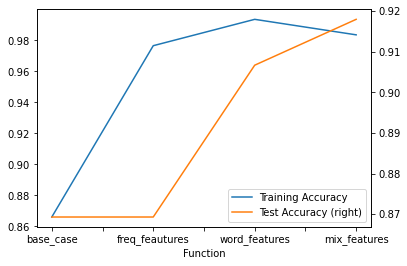

In [5]:
results_list = []

# For each feature function, try to classify the test sets
for fn in all_features:
    train_set = [(fn(n), g) for (n,g) in train_names]
    test_set = [(word_features(n), g) for (n,g) in test_names]
    
    # make a classifier from the training set
    classifier = nltk.classify.DecisionTreeClassifier.train(train_set)
    
    # Print the classifier logic
    accuracy_train = nltk.classify.accuracy(classifier, train_set)
    accuracy_test = nltk.classify.accuracy(classifier, test_set)

    results_list.append([fn.__name__, accuracy_train, accuracy_test])


results_df = pd.DataFrame(results_list,
                          columns=['Function', 
                                   'Training Accuracy', 
                                   'Test Accuracy',
                                   ])

results_df.head()
ax=results_df.plot('Function','Training Accuracy')
results_df.plot('Function','Test Accuracy',secondary_y=True, ax=ax)


### Searching for SPAM through bigrams 

In [6]:
data[ data['Spam_Value'] == 'spam'  ]['Str']

2       Free entry in 2 a wkly comp to win FA Cup fina...
5       FreeMsg Hey there darling it's been 3 week's n...
8       WINNER!! As a valued network customer you have...
9       Had your mobile 11 months or more? U R entitle...
11      SIX chances to win CASH! From 100 to 20,000 po...
                              ...                        
5537    Want explicit SEX in 30 secs? Ring 02073162414...
5540    ASKED 3MOBILE IF 0870 CHATLINES INCLU IN FREE ...
5547    Had your contract mobile 11 Mnths? Latest Moto...
5566    REMINDER FROM O2: To get 2.50 pounds free call...
5567    This is the 2nd time we have tried 2 contact u...
Name: Str, Length: 747, dtype: object

In [7]:
from nltk.collocations import *
from nltk import bigrams
import nltk

def tokenize(sentences):
    for sent in nltk.sent_tokenize(sentences.lower()):
        for word in nltk.word_tokenize(sent):
              yield word

In [8]:
sentences = data[ data['Spam_Value'] == 'spam'  ]['Str'].tolist()
all_spam = " ".join(sentences).lower()
words = tokenize(all_spam)
text = nltk.Text(words)
print("Collocated spam words")
text.collocations(15)
print("\n\n")


# Use a bigram collocation finder
bigram_measures = nltk.collocations.BigramAssocMeasures()

tokens = nltk.wordpunct_tokenize(all_spam)
finder = BigramCollocationFinder.from_words(tokens)
finder.apply_freq_filter(3)
finder.nbest(bigram_measures.pmi, 10)

print("bigram collocations")
print(sorted(finder.nbest(bigram_measures.pmi, 10)))

Collocated spam words
please call; await collection; valid 12hrs; account statement; land
line; å£1000 cash; identifier code; 800 un-redeemed; 2003 account;
every week; 2nd attempt; prize guaranteed; half price; secret admirer;
dating service



bigram collocations
[('08701417012', 'profit'), ('14', 'tcr'), ('alfie', 'moon'), ('city', 'break'), ('cm2', '9ae'), ('cross', 'ntwk'), ('ibhltd', 'ldnw15h'), ('m26', '3uz'), ('press', '0'), ('sk3', '8wp')]


### Takeaways